In [1]:

import numpy as np

import keras
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Defining the input data path
train_path = r"C:\Users\Lenovo\Documents\data\Train"
val_path = r"C:\Users\Lenovo\Documents\data\Validation"
test_path = r"C:\Users\Lenovo\Documents\data\Test"

In [3]:

labels = ['covid', 'normal']
img_size = 150
def get_data(data_dir):

    data = []
    data_labels = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append(np.array(resized_arr))
                data_labels.append(class_num)
            except Exception as e:
                print(e)
    return np.array(data), np.array(data_labels)

In [4]:
 #Fetching all the data

train_images, train_labels = get_data(train_path)
val_images, val_labels = get_data(val_path)
test_images, test_labels = get_data(test_path)

In [5]:
print('Train data shape: ',train_images.shape)
print('Validation data shape: ',val_images.shape)
print('Test data shape: ',test_images.shape)

Train data shape:  (5984, 150, 150)
Validation data shape:  (624, 150, 150)
Test data shape:  (624, 150, 150)


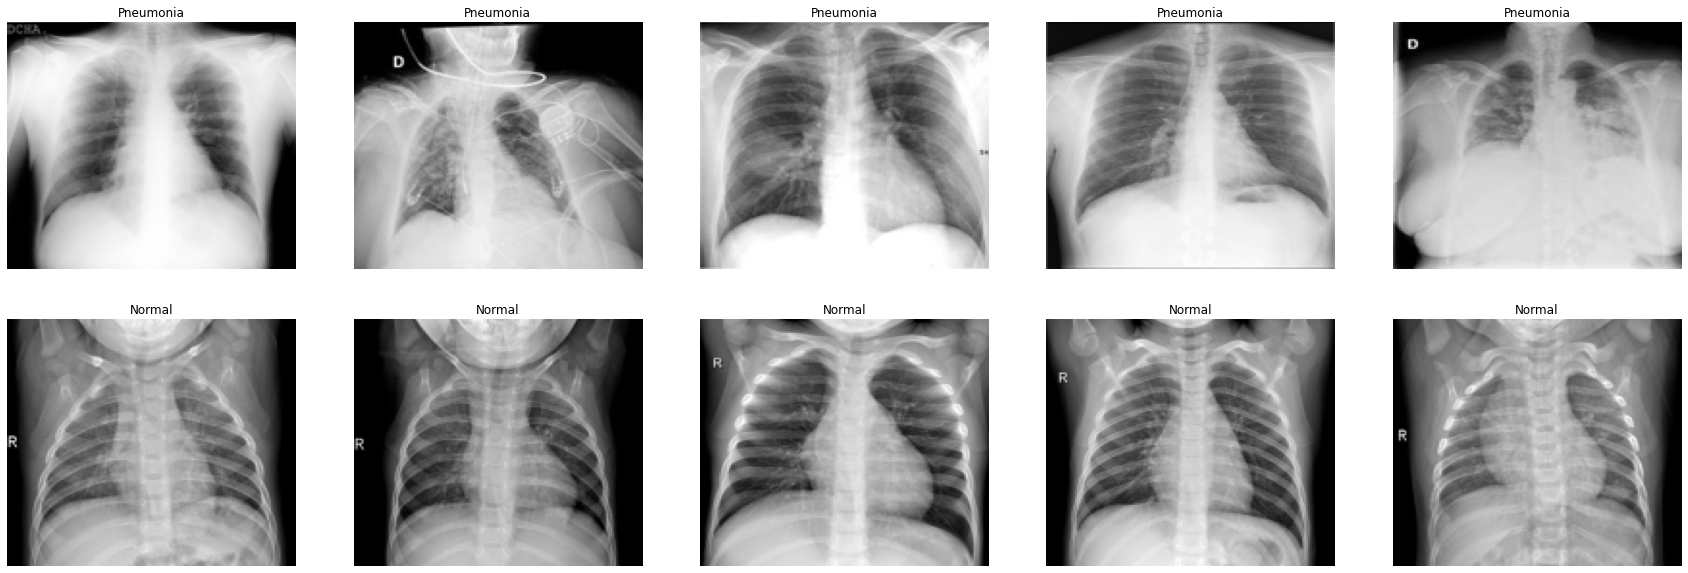

In [6]:
# Visualizing a few samples of both the pneumonia and the normal class

covid_samples = train_images[np.where(train_labels==0)[0][:5],:] # Get 5 covid samples
normal_samples = train_images[np.where(train_labels==1)[0][:5],:] # Get 5 normal samples

cp_samples = np.concatenate((covid_samples, normal_samples), axis=0) # Concatenate the samples
samples = np.array(cp_samples)

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = samples[i]
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("COVID")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

<AxesSubplot:ylabel='count'>

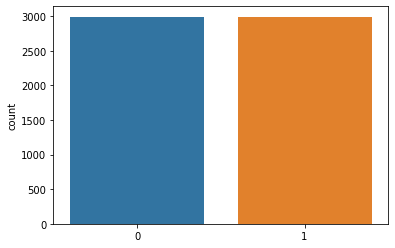

In [7]:
# Visualizing counts of each class with 0 - Pneumonia and 1 - Normal
sns.countplot(x=np.array(train_labels))

In [8]:
# Performs image augmentation by translating and rotating image by random amounts

def augment_image(image, max_translation, max_rotation):
    translation = float(max_translation*np.random.rand()*(0.5-np.random.rand()))
    rotation = float(max_rotation*np.random.rand()*(0.5-np.random.rand()))
    transformer = AffineTransform(translation=(translation,0), rotation=rotation)
    image = warp(image, transformer)
    return image

In [9]:
normal_samples = len(train_labels[train_labels==1])
print('Number of normal samples: ', normal_samples)

augment_shape = (normal_samples*2,) + train_images.shape[1:]
augmented_images = np.zeros(shape=augment_shape)
augmented_labels = np.zeros(shape=(augment_shape[0],1))

# Augmenting the data by creating 2 new images from each original image of class Normal
x = 0
for i in range(len(train_images)):
    if train_labels[i] == 1:
        augmented_images[x] = augment_image(train_images[i], 20, 20/180*np.pi)
        augmented_labels[x] = train_labels[i]
        augmented_images[x+1] = augment_image(train_images[i], 20, 20/180*np.pi)
        augmented_labels[x+1] = train_labels[i]
        x += 2

# Merging the new data with the original training data
train_images = np.concatenate((train_images, augmented_images), axis=0)
train_labels = np.concatenate((train_labels.reshape(-1,1), augmented_labels), axis=0)

Number of normal samples:  2992


In [10]:
# Normalizing the data
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
val_images /= 255
test_images /= 255

In [11]:
train_images = train_images.reshape(-1,img_size*img_size)
val_images = val_images.reshape(-1,img_size*img_size)
test_images = test_images.reshape(-1,img_size*img_size)

In [12]:
train_images = np.array(train_images.reshape(-1,img_size, img_size, 1))
val_images = np.array(val_images.reshape(-1,img_size, img_size, 1))
test_images = np.array(test_images.reshape(-1,img_size, img_size, 1))
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [13]:
model = keras.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size, img_size,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [15]:
history = model.fit(train_images, 
                    train_labels, 
                    validation_data = (val_images,val_labels),
                    epochs = 5, 
                    callbacks = [learning_rate_reduction])

Epoch 1/5
374/374 [==============================] - 444s 1s/step - loss: 0.4093 - accuracy: 0.8981 - precision: 0.9378 - recall: 0.9256 - val_loss: 3.9423 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/5
374/374 [==============================] - 463s 1s/step - loss: 0.2056 - accuracy: 0.9465 - precision: 0.9672 - recall: 0.9613 - val_loss: 0.1345 - val_accuracy: 0.9519 - val_precision: 0.9406 - val_recall: 0.9647 - lr: 0.0010
Epoch 3/5
374/374 [==============================] - 467s 1s/step - loss: 0.1325 - accuracy: 0.9606 - precision: 0.9756 - recall: 0.9718 - val_loss: 0.1256 - val_accuracy: 0.9535 - val_precision: 0.9327 - val_recall: 0.9776 - lr: 0.0010
Epoch 4/5
374/374 [==============================] - 484s 1s/step - loss: 0.1027 - accuracy: 0.9674 - precision: 0.9793 - recall: 0.9772 - val_loss: 0.0663 - val_accuracy: 0.9792 - val_precision: 0.9716 - val_recall: 0.9872 - lr: 0.0010
Epoch 5/5
374/374 [=========================

In [20]:
# Predicting on validation set
preds = model.predict(val_images)
preds[preds<0.5] = 0
preds[preds>=0.5] = 1
print(classification_report(preds, val_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91       371
         1.0       0.81      1.00      0.89       253

    accuracy                           0.90       624
   macro avg       0.90      0.92      0.90       624
weighted avg       0.92      0.90      0.90       624



In [21]:
# Predicting on test set
test_predictions = model.predict(test_images)
test_predictions[test_predictions<0.5] = 0
test_predictions[test_predictions>0.5] = 1
print(classification_report(test_predictions, test_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89       386
         1.0       0.76      1.00      0.86       238

    accuracy                           0.88       624
   macro avg       0.88      0.90      0.88       624
weighted avg       0.91      0.88      0.88       624



In [22]:
model.save('covid-19 classification-final_model.h5')

20/20 - 5s - loss: 0.3839 - accuracy: 0.8782 - precision: 0.9958 - recall: 0.7596 - 5s/epoch - 254ms/step


ValueError: too many values to unpack (expected 2)

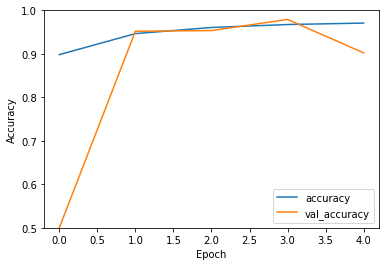

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)